<a href="https://colab.research.google.com/github/PrithviRaj037/PyTorchProjects/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pirthviraj
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:06<00:00, 107MB/s] 


In [2]:
# PyTorch main library for tensor computation
import torch

# For using neural network modules like Linear, Conv2d, etc.
from torch import nn

# Optimizer for training neural networks; Adam is commonly used for its efficiency
from torch.optim import Adam

# (FIXED TYPO BELOW)
# Tools to perform image transformations (resize, normalize, etc.) for preprocessing
import torchvision.transforms as transforms

# Classes to handle and load datasets for training and evaluation
from torch.utils.data import Dataset, DataLoader

# For encoding class labels as integers (e.g., 'cat', 'dog' → 0, 1)
from sklearn.preprocessing import LabelEncoder

# To visualize data and training performance (e.g., loss curves)
import matplotlib.pyplot as plt

# To load and manipulate images
from PIL import Image  # Fixed: should be 'Image' not 'image'

# To read and manipulate CSV data, labels, etc.
import pandas as pd

# Provides numerical operations, array manipulations, etc.
import numpy as np

# To interact with the file system (e.g., list image files in a folder)
import os

device = "cuda" if torch .cuda.is_available() else "cpu"
print("Device available:", device)


Device available: cuda


In [3]:
# Initialize empty lists to store image file paths and their corresponding labels
image_path = []
labels = []

# Loop through each folder (e.g., 'train', 'val', 'test') in the dataset directory
for i in os.listdir("/content/animal-faces/afhq"):
    # Loop through each label folder (e.g., 'cat', 'dog', 'wild') within that split
    for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
        # Loop through each image file inside the label folder
        for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
            # Append the full image path to the image_path list
            image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")

            # Append the corresponding label (e.g., 'cat', 'dog') to the labels list
            labels.append(label)
# Create a pandas DataFrame by combining the image paths and their corresponding labels
# 'zip(image_path, labels)' pairs each image path with its label (like: [("/path/to/image1.jpg", "cat"), ...])
# The 'columns' argument names the two columns: "image_path" and "labels"
data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])

# 5. Check unique labels
print(data_df["labels"].unique())

# Display the first 5 rows of the DataFrame to quickly check the data
data_df.head()

['wild' 'dog' 'cat']


,image_path,labels
0,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
3,/content/animal-faces/afhq/val/wild/pixabay_wi...,wild
4,/content/animal-faces/afhq/val/wild/pixabay_wi...,wild


In [4]:
# Randomly select 70% of the data for the initial training set
train = data_df.sample(frac=0.7)

# The remaining 30% of the data becomes the test set (by dropping training data from the original)
test = data_df.drop(train.index)

# From the training set, randomly take 50% as the validation set
val = train.sample(frac=0.5)

# Drop the validation data from the training set to get the final training data
train = train.drop(val.index)
#.shape is an attribute of pandas DataFrames (or NumPy arrays).

# It returns a tuple in the format:
print(train.shape)
print(val.shape)
print(test.shape)

(5645, 2)
(5646, 2)
(4839, 2)


In [5]:
label_encoder = LabelEncoder() # Encode the string classes to numeric
label_encoder.fit(data_df['labels']) # Fit the label encoder on our own data

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)


In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label


In [7]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)


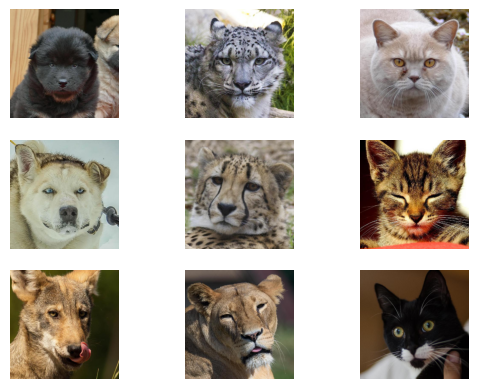

In [9]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_path'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

In [10]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [12]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device


In [13]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

In [15]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 2.2363 Train Accuracy 72.7547
              Validation Loss: 1.131 Validation Accuracy: 88.576
Epoch 2/10, Train Loss: 0.9467 Train Accuracy 90.1329
              Validation Loss: 1.0429 Validation Accuracy: 88.2217
Epoch 3/10, Train Loss: 0.6742 Train Accuracy 93.0912
              Validation Loss: 0.8187 Validation Accuracy: 91.3744
Epoch 4/10, Train Loss: 0.5213 Train Accuracy 94.7033
              Validation Loss: 0.7946 Validation Accuracy: 91.8349
Epoch 5/10, Train Loss: 0.3584 Train Accuracy 96.7405
              Validation Loss: 0.6333 Validation Accuracy: 93.8363
Epoch 6/10, Train Loss: 0.2869 Train Accuracy 96.8822
              Validation Loss: 0.594 Validation Accuracy: 94.226
Epoch 7/10, Train Loss: 0.2071 Train Accuracy 98.0868
              Validation Loss: 0.8171 Validation Accuracy: 92.5611
Epoch 8/10, Train Loss: 0.1431 Train Accuracy 98.7777
              Validation Loss: 0.5402 Validation Accuracy: 94.7751
Epoch 9/10, Train Loss: 0.139 Train 

In [16]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 94.627 and Loss is 0.0515


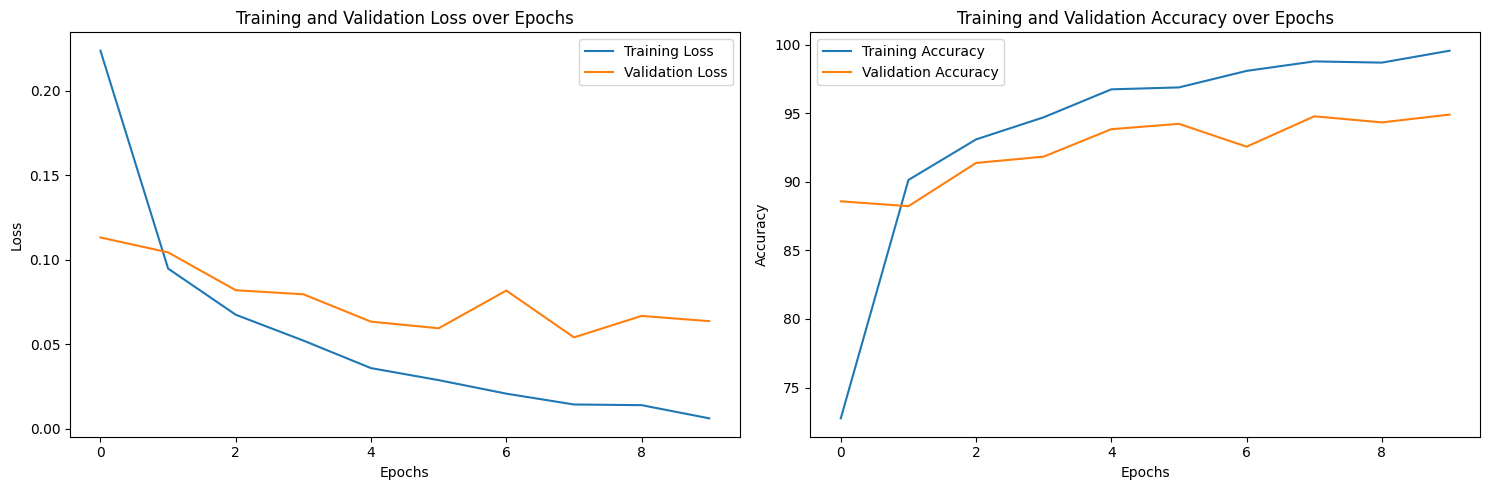

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

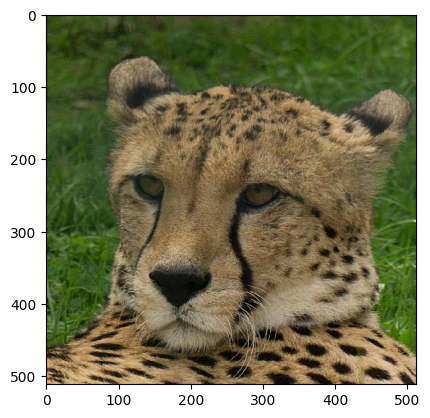


Prediction: 

['wild']


In [19]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
random_image_path = data_df.sample(n=1)['image_path'].iloc[0]
image = Image.open(random_image_path)
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
print(predict_image(random_image_path))